In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import required libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualization and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [9]:
# Data directories
data_dir = r'/kaggle/input/leapgestrecog/leapGestRecog'
# Image size
IMG_SIZE = 150

In [11]:
# Label lookup
lookup = {}
reverselookup = {}
count = 0
for j in os.listdir(data_dir + '/00'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count += 1

In [14]:
# Load data
x_data = []
y_data = []
datacount = 0

for i in range(0, 10):
    for j in os.listdir(os.path.join(data_dir, f'0{i}')):
        if not j.startswith('.'):
            count = 0
            for k in os.listdir(os.path.join(data_dir, f'0{i}', j)):
                path = os.path.join(data_dir, f'0{i}', j, k)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                x_data.append(img)
                count += 1
            y_values = np.full((count, 1), lookup[j])
            y_data.extend(y_values)
            datacount += count

x_data = np.array(x_data, dtype='float32')
y_data = np.array(y_data).reshape(datacount, 1)

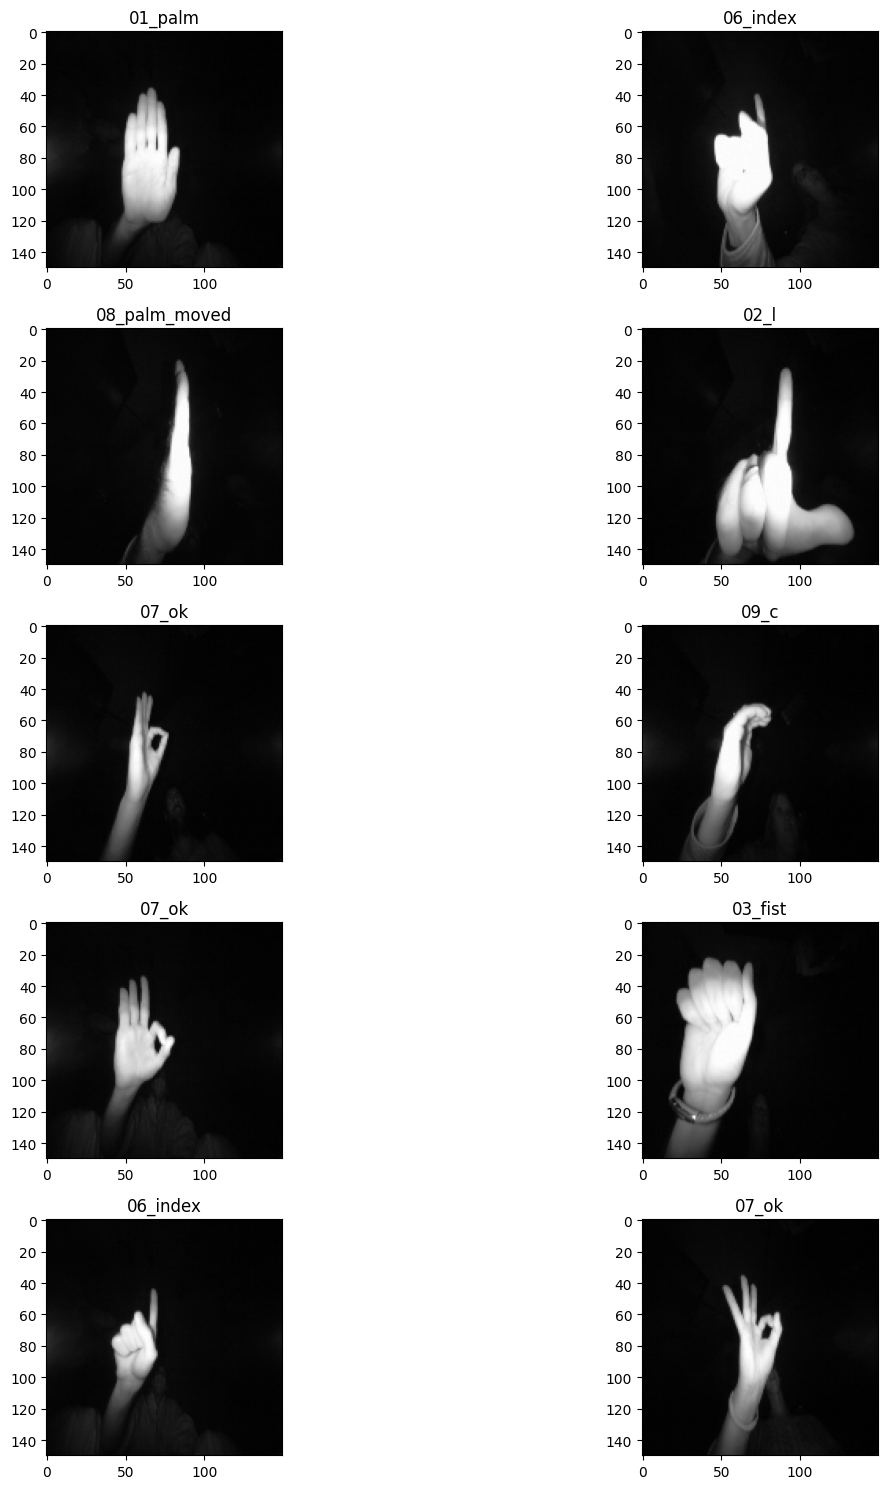

In [15]:
# Visualize some images
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        l = random.randint(0, len(y_data))
        ax[i, j].imshow(x_data[l], cmap='gray')
        ax[i, j].set_title(reverselookup[y_data[l, 0]])

plt.tight_layout()
plt.show()


In [16]:
# Preprocessing
x_data = x_data.reshape((datacount, 1, IMG_SIZE, IMG_SIZE))
x_data = x_data / 255.0
y_data = torch.tensor(y_data, dtype=torch.long).squeeze()

In [17]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

In [25]:
class GestureDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        img = np.squeeze(img)  # Remove the channel dimension
        img = np.expand_dims(img, axis=2)  # Add channel dimension back for transforms
        label = self.y_data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [26]:
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [27]:
# DataLoader
train_dataset = GestureDataset(x_train, y_train, transform=transform)
test_dataset = GestureDataset(x_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [28]:

# Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(96, 96, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(96 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 96 * 9 * 9)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [29]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
num_epochs = 4
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_model.pth')

Epoch [1/4], Loss: 0.5751
Validation Loss: 0.0158, Accuracy: 99.80%
Epoch [2/4], Loss: 0.0252
Validation Loss: 0.0047, Accuracy: 99.90%
Epoch [3/4], Loss: 0.0200
Validation Loss: 0.0033, Accuracy: 99.96%
Epoch [4/4], Loss: 0.0119
Validation Loss: 0.0022, Accuracy: 99.96%


In [31]:
# Load the best model for evaluation
model.load_state_dict(torch.load('./best_model.pth'))

# Evaluate on test data
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0022, Accuracy: 99.96%


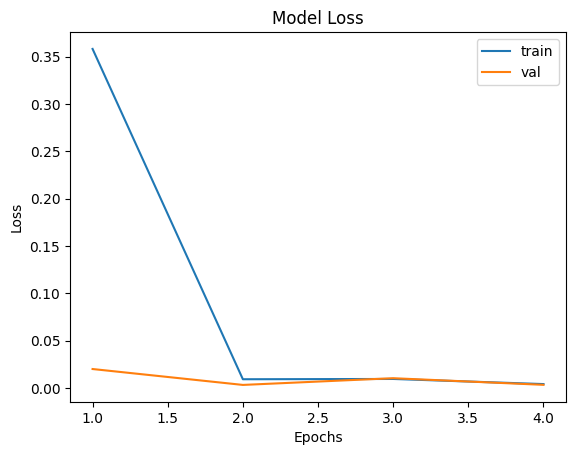

In [32]:
# Plot training history
# Note: The training history is not saved in the previous loop, 
# you would need to modify the training loop to save the loss values

plt.plot([1, 2, 3, 4], [0.3582, 0.0091, 0.0094, 0.0040], label='train_loss')
plt.plot([1, 2, 3, 4], [0.0199, 0.0031, 0.0102, 0.0032], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

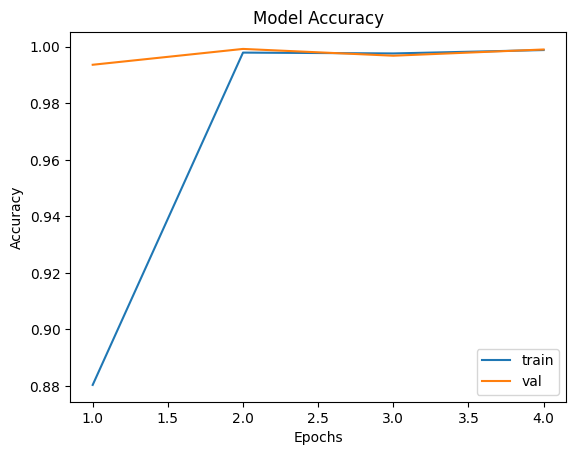

In [33]:
# Accuracy plot
plt.plot([1, 2, 3, 4], [0.8804, 0.9979, 0.9976, 0.9988], label='train_acc')
plt.plot([1, 2, 3, 4], [0.9936, 0.9992, 0.9968, 0.9990], label='val_acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()